In [1]:
import numpy as np                          # Array creation & manipulation
import matplotlib.pyplot as plt             # Plotting
#plt.style.use('default')            # Choose a plot style that suits your environment ('default', 'classic', 'dark_background
import gpytorch
import torch
torch.set_default_dtype(torch.double) #added this because of https://github.com/pytorch/botorch/issues/2182
import json
import scipy
import os
import datetime 
from openpmd_viewer.addons import LpaDiagnostics

In [2]:
#i made fbpic_wrapper into a package to be able to handle it easier
from fbpic_wrapper import SimForeman

Beam Waist
9.614426189210296e-06
RMS Beam Duration (exp(-t^2/tau^2))
2.972626301008067e-14
Angular Frequency
2354564459136066.5
Peak Intensity in W/cm^2
2.6220034246575346e+19
Normalized Vector Potential
3.5
Peak Electric Field in TV/m
14.043750000000001
Pulse Energy in Joules
2.2596571232291924


RMS Beam Duration (exp(-t^2/tau^2))
2.5479654008640572e-14
Beam Waist (exp(-2r^2/w0^2))
8.280887552808186e-06
Angular Frequency
2354564459136066.5
Peak Intensity in W/cm^2
9.439212328767126e+18
Normalized Vector Potential
2.1
Peak Electric Field in TV/m
8.426250000000001
Pulse Energy in Joules
0.5172557075367022
RMS Beam Duration (exp(-t^2/tau^2))
2.5479654008640572e-14
Peak Intensity in W/cm^2
1.3377568493150687e+19
Peak Electric Field in TV/m
10.031250000000002
Pulse Energy in Joules
0.2672593780106513


In [3]:
#define initial sim foldernur
initial_sims="path"
initial_results =  np.load(initial_sims+"results.npz")
num_init_sims=initial_results['x_train'].size #14#8#10

In [4]:
#define old runs that should be included in the initial x and y data
old_runs =  []
x_old=np.empty(0)
y_old=np.empty(0)
for old_run in old_runs:
    old_results = np.load(old_run+"results.npz")
    x_old = np.append(x_old, old_results['x_train'])
    y_old = np.append(y_old, old_results['max_chrg_in_bounds'])
    uz_bounds = old_results['uz_bounds']

In [5]:
run = 'run_simple-zf'+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
try:
    os.mkdir("path"+run)
except:
    print('Path exists')

In [6]:
#modifying sys.argv to succesfully call SimForeman or other scripts that only work with args
import sys
from contextlib import contextmanager

@contextmanager
def patched_argv(new_args):
    original_argv = sys.argv
    sys.argv = new_args
    try:
        yield
    finally:
        sys.argv = original_argv

In [7]:
#get all folders in a directory
def get_folders(path):
    try:
        all_entries = [os.path.join(path, d) for d in os.listdir(path)]
        folders = [entry for entry in all_entries if os.path.isdir(entry)]
    except:
        print('Smth went wrong when trying to list all folders in path')
    return folders

In [8]:
#get initial results
if x_old.size == 0:
    x_train = initial_results['x_train']
    y_train = initial_results['max_chrg_in_bounds']
    uz_bounds = initial_results['uz_bounds']
    max_chrg_it = initial_results['max_chrg_it']
else:
    x_train = x_old
    y_train = np.append(initial_results['max_chrg_in_bounds'],y_old)
    max_chrg_it = np.append(initial_results['max_chrg_it'],old_results['max_chrg_it'])

max_chrg_in_bounds = y_train


In [9]:
with open('params-to-opt-zf.json','r') as file:
    boundsD = json.load(file)
bounds=np.array([boundsD['laser_params']['a0'],boundsD['laser_params']['waist'],boundsD['laser_params']['zf'],boundsD['other_params']['species']['Hydrogen']['profile_params']['plateau'],boundsD['other_params']['species']['Nitrogen']['profile_params']['start'],boundsD['other_params']['species']['Nitrogen']['density']])

In [10]:
#initialize tensors

x_trainT = torch.from_numpy(x_train).view(-1,1)
max_chrg_in_boundsT = torch.from_numpy(np.abs(y_train)).view(-1,1)
boundsT =torch.from_numpy(bounds).T
boundszfT = torch.from_numpy(np.array(boundsD['laser_params']['zf'])).view(2,1)
#boundszfT2 = torch.from_numpy(np.array([boundsD['laser_params']['zf']]))

print(x_trainT)

tensor([[0.0008],
        [0.0007],
        [0.0007],
        [0.0008],
        [0.0005],
        [0.0004],
        [0.0003],
        [0.0011],
        [0.0009],
        [0.0009],
        [0.0011],
        [0.0008],
        [0.0013],
        [0.0011]])


In [11]:
#get latest folder in a file 
def latest_scan_entry(run):
    latest_folder = max(get_folders('./scans/'+run), key=os.path.getmtime, default=None)
    return latest_folder


In [12]:
boundszfT

tensor([[0.0001],
        [0.0015]])

In [13]:
max_chrg_in_boundsT

tensor([[9.1750e-13],
        [1.7322e-12],
        [1.7551e-12],
        [1.4399e-12],
        [3.2571e-12],
        [5.5593e-12],
        [2.2373e-11],
        [1.9889e-13],
        [2.6864e-13],
        [6.4774e-13],
        [1.0667e-14],
        [1.0343e-12],
        [0.0000e+00],
        [3.4784e-14]])

In [14]:
x_trainT

tensor([[0.0008],
        [0.0007],
        [0.0007],
        [0.0008],
        [0.0005],
        [0.0004],
        [0.0003],
        [0.0011],
        [0.0009],
        [0.0009],
        [0.0011],
        [0.0008],
        [0.0013],
        [0.0011]])

x_train: tensor([[0.0008],
        [0.0007],
        [0.0007],
        [0.0008],
        [0.0005],
        [0.0004],
        [0.0003],
        [0.0011],
        [0.0009],
        [0.0009],
        [0.0011],
        [0.0008],
        [0.0013],
        [0.0011]])


/hkfs/home/project/hk-project-p0024137/ng8194/fbpicBO/lib64/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple-zf2025-08-28_22-16-55/iter_params0.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-16-56
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-16-56 2025-08-28_22-16-56
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 27 ms/stepK
Total time ta

100%|██████████| 50/50 [00:00<00:00, 191.34it/s]


Making Scatter Plot
Making Profile
39600
2.4749894308107225


100%|██████████| 50/50 [00:00<00:00, 88.86it/s]


(np.float64(412.4895833333657), np.float64(0.16499999999999998))
Making Energies
Q = 22.64 (pC)


100%|██████████| 50/50 [00:00<00:00, 357.40it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple-zf2025-08-28_22-16-55/iter_params1.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-18-39
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-18-39 2025-08-28_22-18-39
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 27 ms/stepK
Total time ta

100%|██████████| 50/50 [00:00<00:00, 194.02it/s]


Making Scatter Plot
Making Profile
39600
2.4749894308107225


100%|██████████| 50/50 [00:00<00:00, 88.03it/s]


(np.float64(412.4895833333657), np.float64(0.16499999999999998))
Making Energies
Q = 18.36 (pC)


100%|██████████| 50/50 [00:00<00:00, 370.09it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple-zf2025-08-28_22-16-55/iter_params2.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-20-13
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-20-13 2025-08-28_22-20-13
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 27 ms/stepK
Total time ta

100%|██████████| 50/50 [00:00<00:00, 196.49it/s]


Making Scatter Plot
Making Profile
39600
2.4749894308107225


100%|██████████| 50/50 [00:00<00:00, 88.36it/s]


(np.float64(412.4895833333657), np.float64(0.16499999999999998))
Making Energies
Q = 25.14 (pC)


100%|██████████| 50/50 [00:00<00:00, 364.80it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple-zf2025-08-28_22-16-55/iter_params3.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-21-45
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-21-45 2025-08-28_22-21-45
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 27 ms/stepK
Total time ta

100%|██████████| 50/50 [00:00<00:00, 195.68it/s]


Making Scatter Plot
Making Profile
39600
2.4749894308107225


100%|██████████| 50/50 [00:00<00:00, 89.57it/s]


(np.float64(412.4895833333657), np.float64(0.16499999999999998))
Making Energies
Q = 23.32 (pC)


100%|██████████| 50/50 [00:00<00:00, 369.85it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple-zf2025-08-28_22-16-55/iter_params4.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-23-15
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-23-15 2025-08-28_22-23-15
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 28 ms/stepK
Total time ta

100%|██████████| 50/50 [00:00<00:00, 190.00it/s]


Making Scatter Plot
Making Profile
39600
2.4749894308107225


100%|██████████| 50/50 [00:00<00:00, 88.46it/s]


(np.float64(412.4895833333657), np.float64(0.16499999999999998))
Making Energies
Q = 23.84 (pC)


100%|██████████| 50/50 [00:00<00:00, 363.36it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple-zf2025-08-28_22-16-55/iter_params5.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-24-46
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-24-46 2025-08-28_22-24-46
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 27 ms/stepK
Total time ta

100%|██████████| 50/50 [00:00<00:00, 191.10it/s]


Making Scatter Plot
Making Profile
39600
2.4749894308107225


100%|██████████| 50/50 [00:00<00:00, 89.23it/s]


(np.float64(412.4895833333657), np.float64(0.16499999999999998))
Making Energies
Q = 22.14 (pC)


100%|██████████| 50/50 [00:00<00:00, 360.68it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple-zf2025-08-28_22-16-55/iter_params6.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-26-19
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-26-19 2025-08-28_22-26-19
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 28 ms/stepK
Total time ta

100%|██████████| 50/50 [00:00<00:00, 194.25it/s]


Making Scatter Plot
Making Profile
39600
2.4749894308107225


100%|██████████| 50/50 [00:00<00:00, 89.03it/s]


(np.float64(412.4895833333657), np.float64(0.16499999999999998))
Making Energies
Q = 27.65 (pC)


100%|██████████| 50/50 [00:00<00:00, 359.28it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple-zf2025-08-28_22-16-55/iter_params7.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-27-51
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-27-51 2025-08-28_22-27-51
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 27 ms/stepK
Total time ta

100%|██████████| 50/50 [00:00<00:00, 188.79it/s]


Making Scatter Plot
Making Profile
39600
2.4749894308107225


100%|██████████| 50/50 [00:00<00:00, 88.30it/s]


(np.float64(412.4895833333657), np.float64(0.16499999999999998))
Making Energies
Q = 21.30 (pC)


100%|██████████| 50/50 [00:00<00:00, 356.92it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple-zf2025-08-28_22-16-55/iter_params8.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-29-23
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-29-23 2025-08-28_22-29-23
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 27 ms/stepK
Total time ta

100%|██████████| 50/50 [00:00<00:00, 192.33it/s]


Making Scatter Plot
Making Profile
39600
2.4749894308107225


100%|██████████| 50/50 [00:00<00:00, 87.15it/s]


(np.float64(412.4895833333657), np.float64(0.16499999999999998))
Making Energies
Q = 23.44 (pC)


100%|██████████| 50/50 [00:00<00:00, 357.20it/s]

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.


----------------------
Load Foreman Main Function
Parsing Args
Assuming single run
Loading Entered Path
/hkfs/home/project/hk-project-p0024137/ng8194/simulations/lapa_bo/scans/run_simple-zf2025-08-28_22-16-55/iter_params9.json
Assuming Mass is equal to electron mass, updating...
Filling in Hydrogen as flat top
Filling in Nitrogen as flat top
Filling in Electrons as profile sum
Summing 1
Summing 2




Running the FullSimHeader to Debug Code
Checking for existing filepath:
Path exists
Loading Timestamp
Name IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-30-56
Defining Filesystem
Loading Filesystem
IPAC9Loop density 10e22  2024-05-14_12-54-362024-05-14_12-54-36 2025-08-28_22-30-56 2025-08-28_22-30-56
4.0

FBPIC (0.26.1)

Running on GPU 

Hydrogen
Loading Hydrogen
Nitrogen
Loading Nitrogen
Electrons
Loading Electrons
Hydrogen
Nitrogen
Electrons
Starting from the Beginning
|███████████████████████████████████| 1229/1229, 0:00:00 left, 27 ms/stepK
Total time ta

100%|██████████| 50/50 [00:00<00:00, 189.06it/s]


Making Scatter Plot
Making Profile
39600
2.4749894308107225


100%|██████████| 50/50 [00:00<00:00, 86.45it/s]


(np.float64(412.4895833333657), np.float64(0.16499999999999998))
Making Energies
Q = 23.23 (pC)


100%|██████████| 50/50 [00:00<00:00, 354.92it/s]


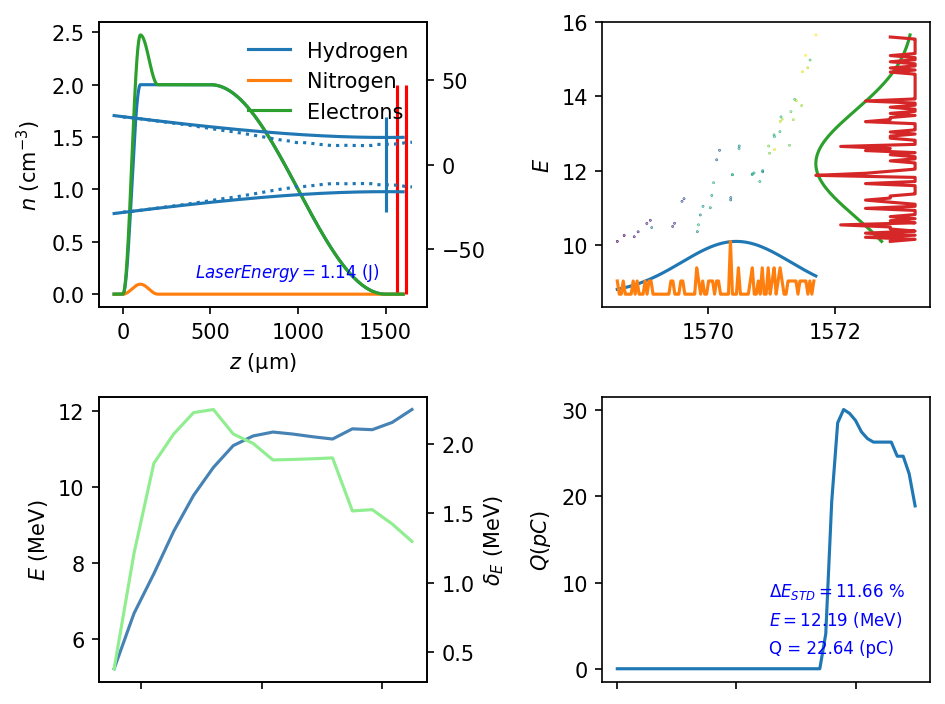

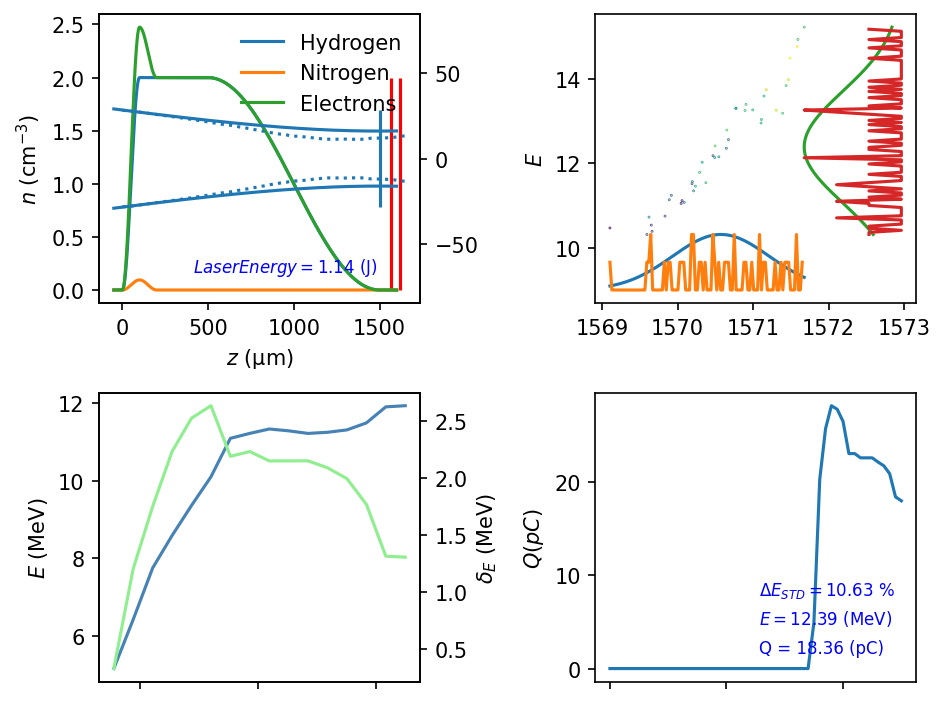

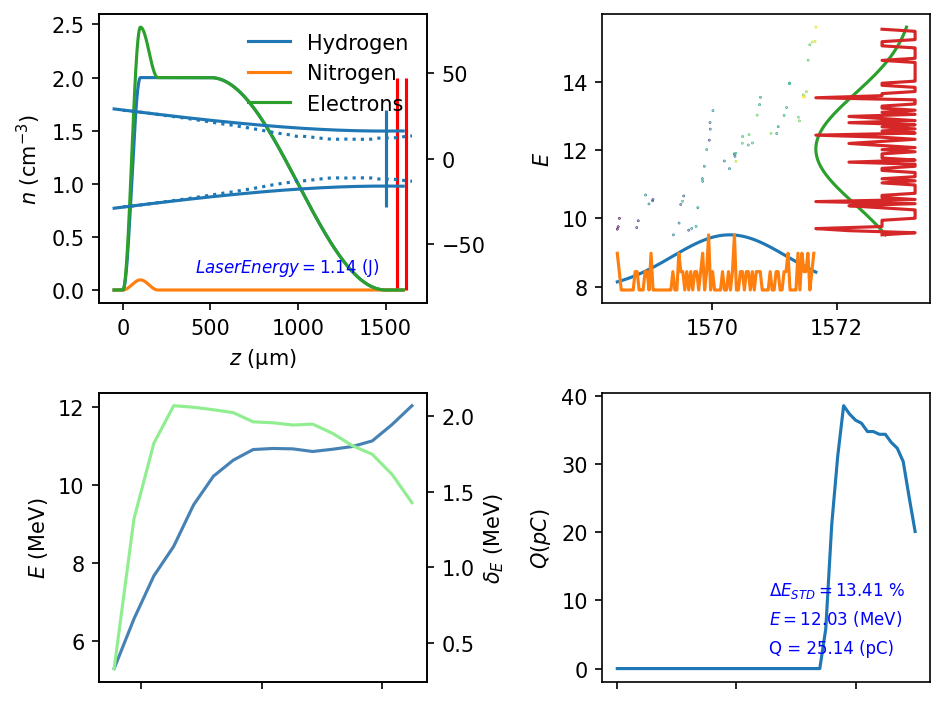

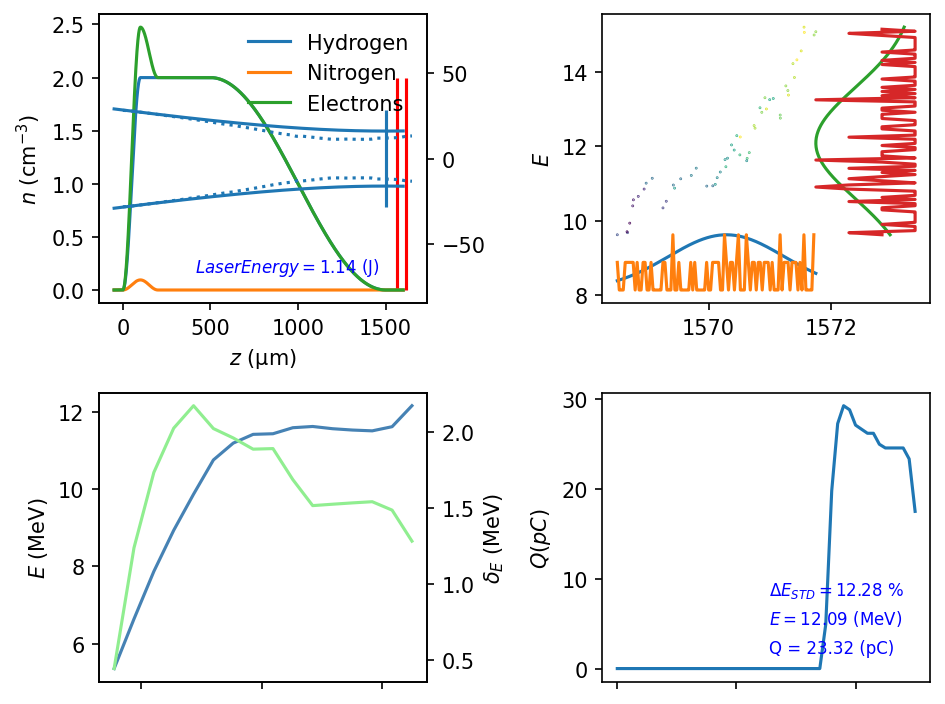

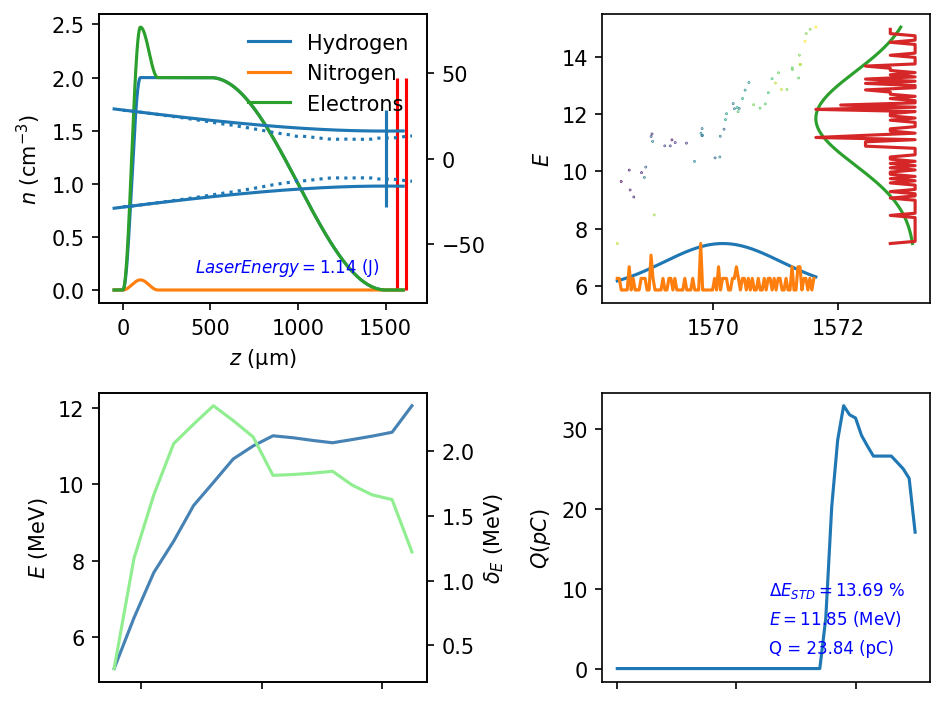

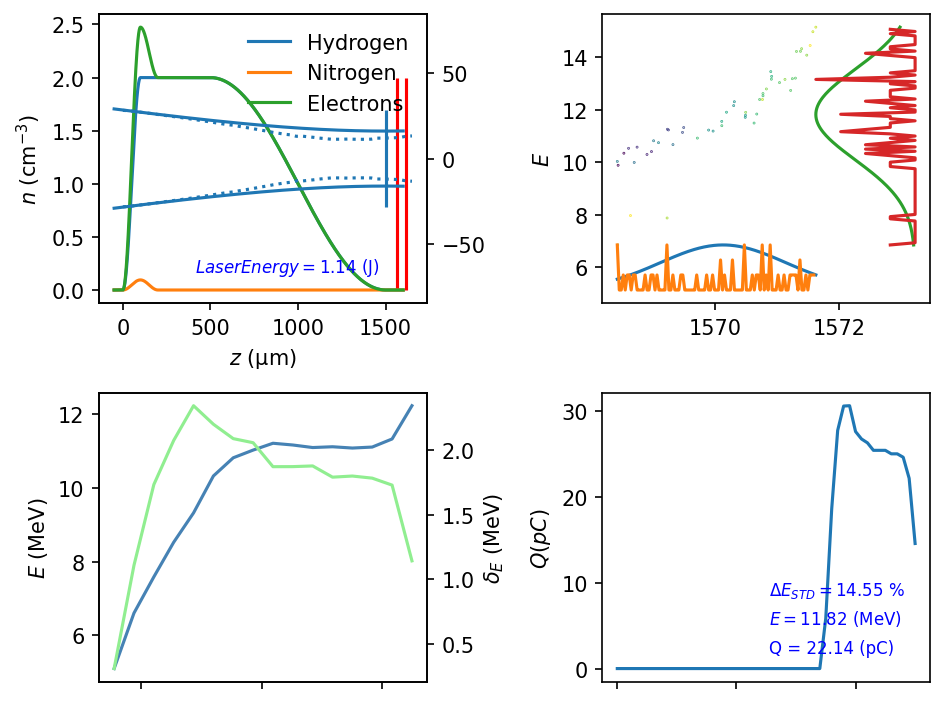

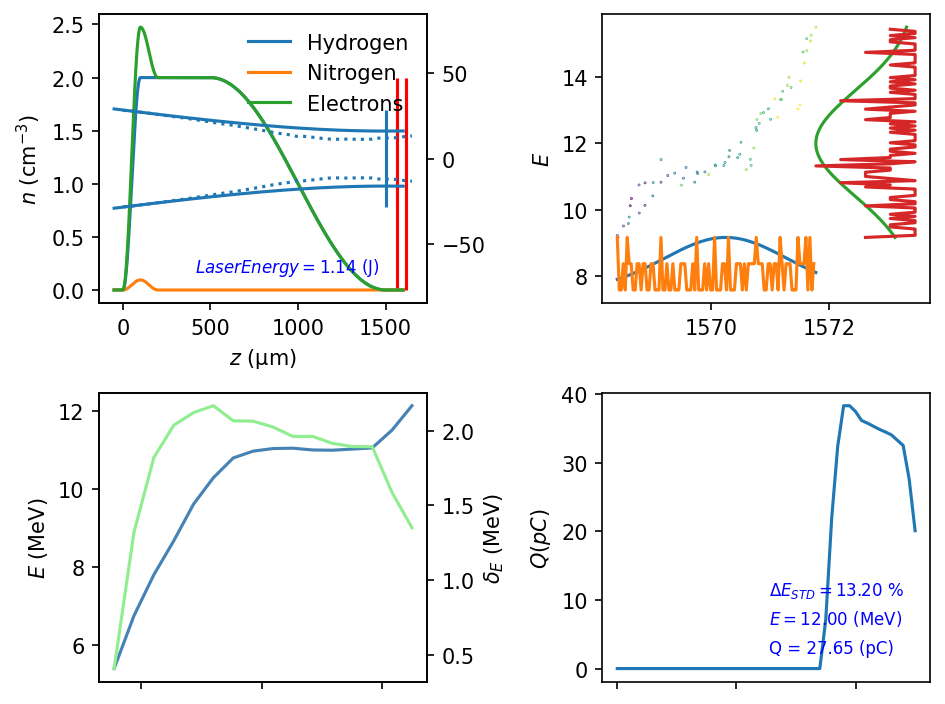

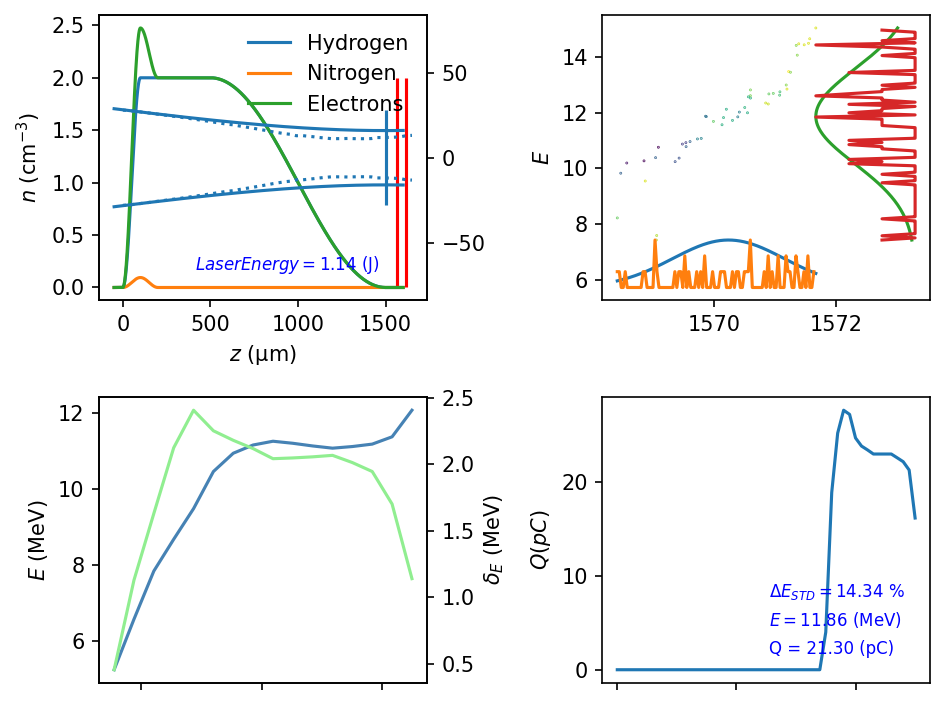

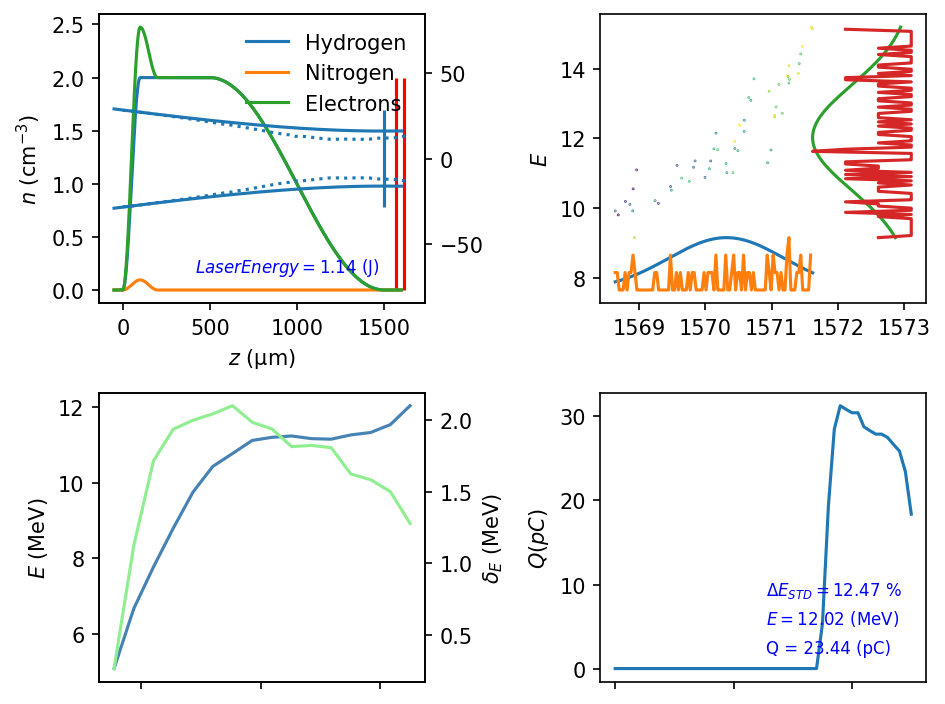

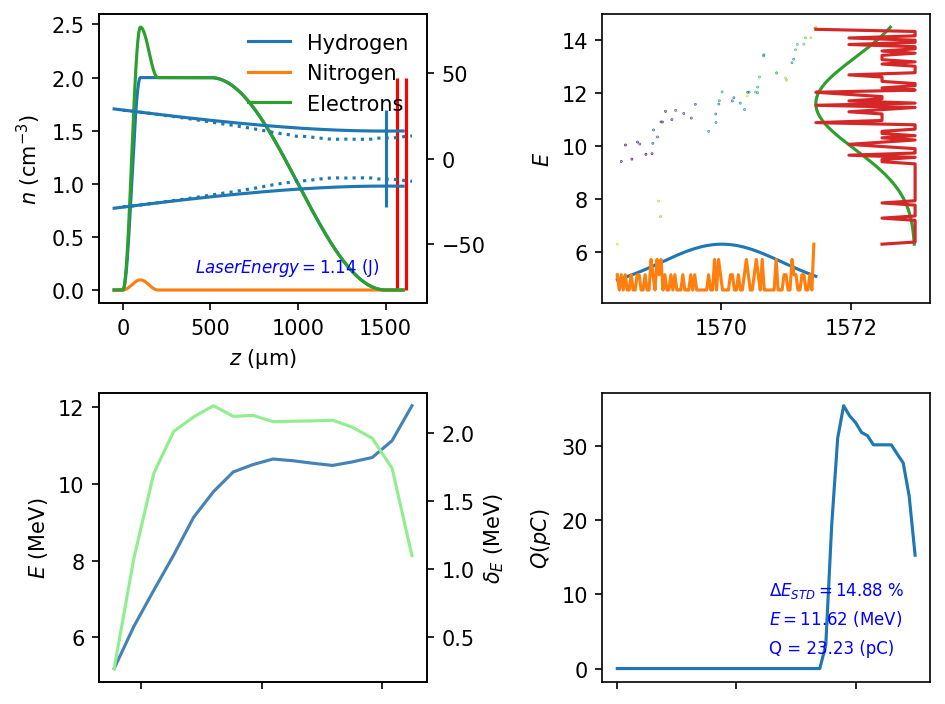

In [15]:
## https://github.com/pytorch/botorch/issues/2182

from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms import Standardize
from botorch.utils.transforms import unnormalize, normalize
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.acquisition.multi_objective.logei import qLogExpectedHypervolumeImprovement
from botorch.acquisition import UpperConfidenceBound

from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood

from botorch.sampling.normal import SobolQMCNormalSampler

from gpytorch.mlls import ExactMarginalLogLikelihood

from copy import deepcopy

BATCH_SIZE=1
#no clue which parameters should be chosen here, copied it from tutorial
NUM_RESTARTS= 10#80# chatgpt says to increase bc its stuck at the maximum bound # 10
RAW_SAMPLES= 256#4096#256
MC_SAMPLES = 128

Y_SCALE_FCTR = 1e13

print('x_train:',x_trainT)
x_trainT = normalize(x_trainT,boundszfT)


#scale objective, to have small std in relation
y_scaled = max_chrg_in_boundsT * Y_SCALE_FCTR

model_cps = []
data_cps = []

for i in range(10):
    train_Yvar = torch.full_like(y_scaled, 1e-6) #apparently needed for noise free observations, otherwise inferred https://botorch.readthedocs.io/en/stable/models.html#botorch.models.gp_regression.SingleTaskGP
    model = SingleTaskGP(x_trainT, y_scaled, train_Yvar, outcome_transform=Standardize(1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)#SumMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    
    # optimize
    acq_func = UpperConfidenceBound(model=model, beta=0.5)
    
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds= boundszfT,#torch.tensor([0., 1.]).view(2,1),#boundszfT,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    )
    
    # observe new values
    x_trainT = torch.cat([x_trainT, normalize(candidates,boundszfT)])
    new_x_train = candidates.detach()
    with open(initial_sims+'init_params10.json','r') as file:
        params = json.load(file)
    params['laser_params']['zf'] = float(new_x_train)
    params['Path'] = "path"+run
    with open("path"+run+f'/iter_params{i}.json', 'w') as json_file:
        json.dump(params, json_file)
    print('----------------------')
    with patched_argv(['SimForeman.py', '--json=load', '--File='+"path"+run+f'/iter_params{i}.json', '--Debug', '--Summarize']):
        SimForeman.main()
        
    ts_2d = LpaDiagnostics(latest_scan_entry(run)+'/diags/hdf5/')
    
    charge_in_bounds = ts_2d.iterate(ts_2d.get_charge, species ='Electrons', select = {'uz':uz_bounds})[39:]#only charges from iteration 40-50, to avoid perverse optimization
    max_chrg_in_bounds = np.append(max_chrg_in_bounds,np.abs(charge_in_bounds[int(np.nanargmin(charge_in_bounds))]))

    max_chrg_in_boundsT = torch.cat([max_chrg_in_boundsT,torch.tensor([[np.abs(charge_in_bounds[int(np.nanargmin(charge_in_bounds))])]])])
    max_chrg_it = np.append(max_chrg_it,int(np.nanargmin(charge_in_bounds)))
    y_scaled = torch.cat([y_scaled,torch.tensor([[np.abs(charge_in_bounds[int(np.nanargmin(charge_in_bounds))])*Y_SCALE_FCTR]])]) 
    #data_cps.append((x_train, y_train))
    #model_cps.append(deepcopy(model))
    

In [16]:
#save inputs and outputs:
np.savez('./scans/'+run+'/results.npz',x_train=unnormalize(x_trainT, boundszfT).numpy(), max_chrg_in_bounds=max_chrg_in_bounds,max_chrg_it=max_chrg_it,uz_bounds=uz_bounds)

In [17]:
#vis

In [18]:
unnormalize(x_trainT, boundszfT)

tensor([[0.0008],
        [0.0007],
        [0.0007],
        [0.0008],
        [0.0005],
        [0.0004],
        [0.0003],
        [0.0011],
        [0.0009],
        [0.0009],
        [0.0011],
        [0.0008],
        [0.0013],
        [0.0011],
        [0.0015],
        [0.0015],
        [0.0015],
        [0.0015],
        [0.0015],
        [0.0015],
        [0.0015],
        [0.0015],
        [0.0015],
        [0.0015]])

In [19]:
max_chrg_in_bounds

array([-9.17500202e-13, -1.73216136e-12, -1.75507798e-12, -1.43988717e-12,
       -3.25711205e-12, -5.55928484e-12, -2.23734853e-11, -1.98890707e-13,
       -2.68644910e-13, -6.47737285e-13, -1.06674588e-14, -1.03430304e-12,
        0.00000000e+00, -3.47836746e-14,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [20]:
max_chrg_it

array([ 7, 11, 11,  7,  9, 11, 11,  2,  7,  7,  0,  6,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

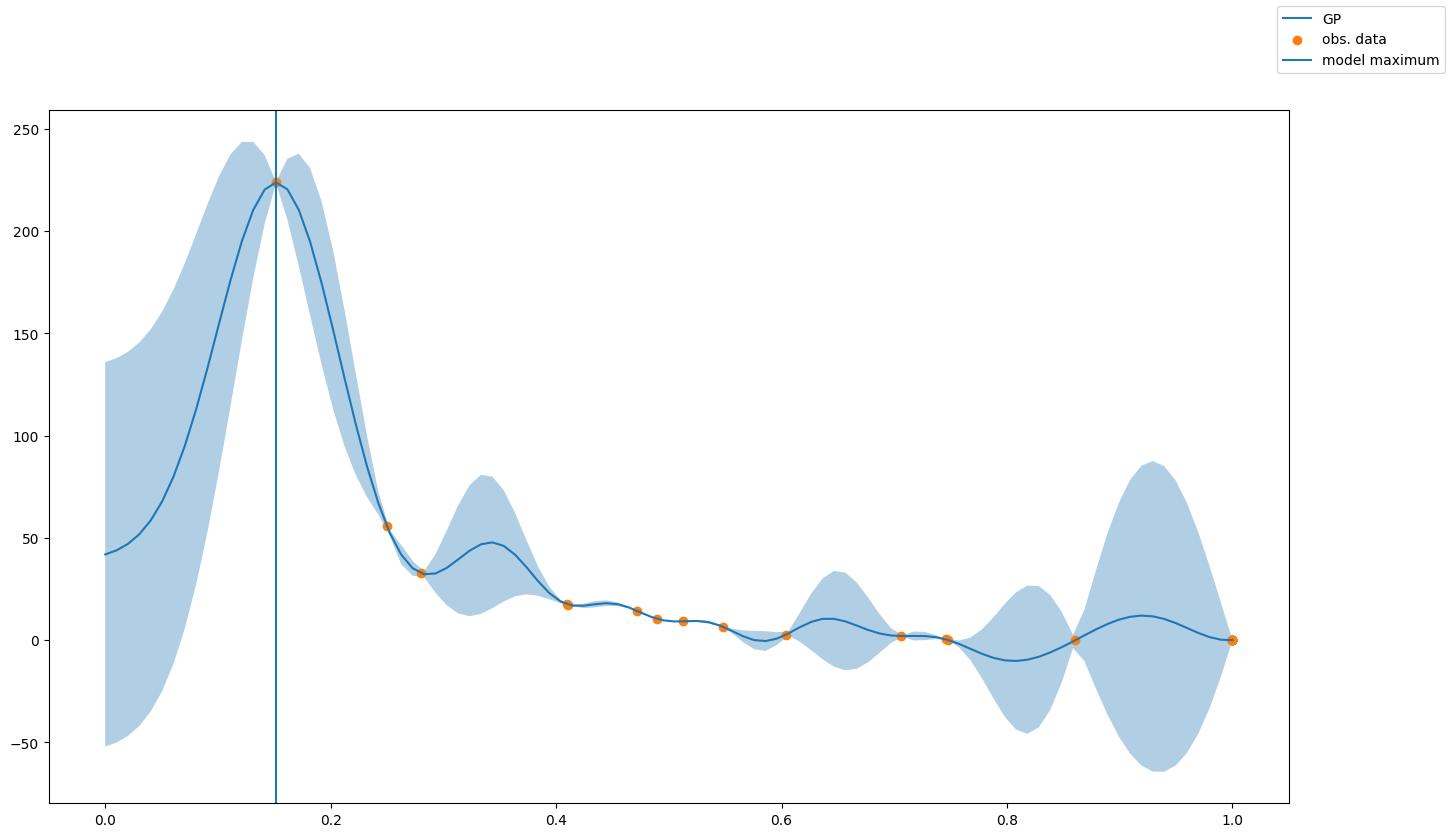

In [21]:
#Visualize

#model_copy = deepcopy(model)

fig, ax = plt.subplots(figsize=(16, 9))
with torch.no_grad():
    x_test = torch.linspace(0,1,100)
    m = model.posterior(x_test).mean.squeeze()
    s = model.posterior(x_test).variance.sqrt().squeeze()
    ax.plot(x_test, m.numpy(), label="GP")
    ax.fill_between(x_test, m+2*s, m-2*s, alpha=0.35)
    #ax.plot(x_test, toy_model(x_test.numpy(), noise_std=0), label="ground truth", ls="--")
    ax.scatter(x_trainT.numpy(), y_scaled.numpy(), label="obs. data")
    #ax.set_title(f"Iteration={i}")
    ax.axvline(x_test[m.argmax()], label="model maximum")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels)#,loc='center')
    fig.savefig('./scans/'+run+'/BO_fig-scaled.pdf', format="pdf")

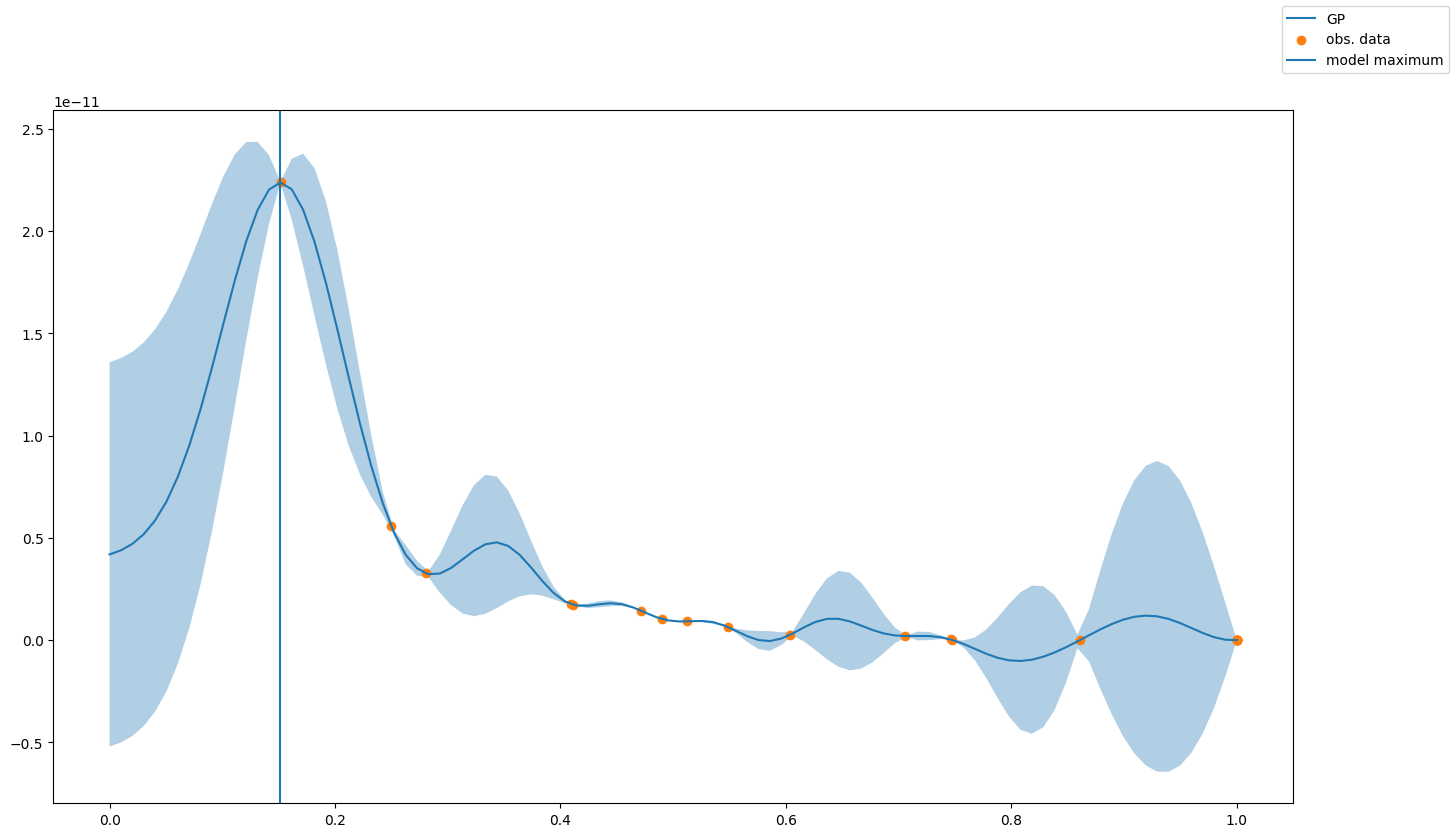

In [22]:
#Visualize

#model_copy = deepcopy(model)

fig, ax = plt.subplots(figsize=(16, 9))
with torch.no_grad():
    x_test = torch.linspace(0,1,100)
    m = model.posterior(x_test).mean.squeeze()/Y_SCALE_FCTR
    s = model.posterior(x_test).variance.sqrt().squeeze()/Y_SCALE_FCTR
    ax.plot(x_test, m.numpy(), label="GP")
    ax.fill_between(x_test, m+2*s, m-2*s, alpha=0.35)
    #ax.plot(x_test, toy_model(x_test.numpy(), noise_std=0), label="ground truth", ls="--")
    ax.scatter(x_trainT.numpy(), y_scaled.numpy()/Y_SCALE_FCTR, label="obs. data")
    #ax.set_title(f"Iteration={i}")
    ax.axvline(x_test[m.argmax()], label="model maximum")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels)#,loc='center')
    fig.savefig('./scans/'+run+'/BO_fig.pdf', format="pdf")